In [1]:
# Standard
import os
import sys
import random
import datetime
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec

# Utils
import h5py

# Deep Learning
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.utils import plot_model

# User defined
sys.path.insert(0, "../")
from architectures.laddernet import LadderNet
from metrics.multiclass_dice import multiclass_dice, dice_lv, dice_la, dice_myo

In [2]:
f = h5py.File("../../data/image_dataset_normalized.hdf5", "r")

In [3]:
train_image_subset = f["train 2ch frames"][:630,:,:,:]
train_mask_subset = f["train 2ch masks"][:630,:,:,:]
test_image_subset = f["train 2ch frames"][630:,:,:,:]
test_mask_subset = f["train 2ch masks"][630:,:,:,:]

image_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=20,
                                    zoom_range=[0.9,1.1], 
                                    shear_range=5,
                                    fill_mode = 'constant', 
                                    cval=0)
mask_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=20,
                                    zoom_range=[0.9,1.1], 
                                    shear_range=5,
                                    fill_mode = 'constant', 
                                    cval=0)

seed = 1
image_datagen.fit(train_image_subset, augment=True, seed=seed)
mask_datagen.fit(train_mask_subset, augment=True, seed=seed)

image_generator = image_datagen.flow(train_image_subset,
                                     shuffle=True,
                                     batch_size=10,
                                     seed=seed)

mask_generator = mask_datagen.flow(train_mask_subset,
                                   shuffle=True,
                                   batch_size=10,
                                   seed=seed)

class MergedGenerators(tf.keras.utils.Sequence):
    def __init__(self, generator1, generator2, batch_size=10):
        self.generator1 = generator1
        self.generator2 = generator2
        self.batch_size = batch_size
        # TODO add a check to verify that all generators have the same length

    def __len__(self):
        return self.generator1.__len__()

    def __getitem__(self, index):

        return (self.generator1.__getitem__(index), self.generator2.__getitem__(index))

train_generator = MergedGenerators(image_generator, mask_generator)

In [4]:
(a,b) = train_generator.__getitem__(0)

In [5]:
a = image_generator.__getitem__(2)
b = mask_generator.__getitem__(2)

In [6]:
model_laddernet = LadderNet(input_size=(384, 384, 1), num_classes=4, filters=10)

In [7]:
for i in range(0, len(model_laddernet.layers)):
    model_laddernet.layers[i].trainable = True

In [8]:
model_laddernet.compile(optimizer=Adam(lr=1e-3), loss='sparse_categorical_crossentropy', metrics=[multiclass_dice, dice_lv, dice_la, dice_myo, "accuracy"])

In [9]:
earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_multiclass_dice', min_delta=0, patience=7, verbose=1, mode="max", restore_best_weights = True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_multiclass_dice', factor=0.5, patience=2, verbose=1, mode="max", min_lr=1e-6)

model_laddernet.fit_generator(train_generator,
               validation_data=(test_image_subset,test_mask_subset),
               steps_per_epoch=63,
               epochs=60,
               callbacks=[earlystop, reduce_lr])

Epoch 1/60
63/63 [==============================] - 126s 2s/step - loss: 1.1777 - multiclass_dice: 0.2503 - dice_lv: 0.3214 - dice_la: 0.1078 - dice_myo: 0.2435 - accuracy: 0.5913 - val_loss: 12.3441 - val_multiclass_dice: 0.0697 - val_dice_lv: 6.6324e-04 - val_dice_la: 0.1046 - val_dice_myo: 4.1357e-05 - val_accuracy: 0.1660
Epoch 2/60
63/63 [==============================] - 122s 2s/step - loss: 0.5476 - multiclass_dice: 0.4841 - dice_lv: 0.6750 - dice_la: 0.0808 - dice_myo: 0.3616 - accuracy: 0.8305 - val_loss: 5.9790 - val_multiclass_dice: 0.1901 - val_dice_lv: 0.0000e+00 - val_dice_la: 0.0000e+00 - val_dice_myo: 0.2332 - val_accuracy: 0.1471
Epoch 3/60
63/63 [==============================] - 123s 2s/step - loss: 0.3721 - multiclass_dice: 0.6386 - dice_lv: 0.7371 - dice_la: 0.4602 - dice_myo: 0.6136 - accuracy: 0.8747 - val_loss: 5.9121 - val_multiclass_dice: 0.3248 - val_dice_lv: 0.3562 - val_dice_la: 0.1165 - val_dice_myo: 0.4075 - val_accuracy: 0.3119
Epoch 4/60
63/63 [========

Epoch 24/60
63/63 [==============================] - 121s 2s/step - loss: 0.1439 - multiclass_dice: 0.8503 - dice_lv: 0.8892 - dice_la: 0.8550 - dice_myo: 0.8126 - accuracy: 0.9430 - val_loss: 0.1226 - val_multiclass_dice: 0.8765 - val_dice_lv: 0.9145 - val_dice_la: 0.8845 - val_dice_myo: 0.8396 - val_accuracy: 0.9523
Epoch 25/60
63/63 [==============================] - 123s 2s/step - loss: 0.1422 - multiclass_dice: 0.8525 - dice_lv: 0.8906 - dice_la: 0.8586 - dice_myo: 0.8145 - accuracy: 0.9436 - val_loss: 0.1186 - val_multiclass_dice: 0.8811 - val_dice_lv: 0.9190 - val_dice_la: 0.8839 - val_dice_myo: 0.8476 - val_accuracy: 0.9536
Epoch 26/60
63/63 [==============================] - 122s 2s/step - loss: 0.1411 - multiclass_dice: 0.8528 - dice_lv: 0.8900 - dice_la: 0.8620 - dice_myo: 0.8144 - accuracy: 0.9441 - val_loss: 0.1211 - val_multiclass_dice: 0.8778 - val_dice_lv: 0.9161 - val_dice_la: 0.8841 - val_dice_myo: 0.8415 - val_accuracy: 0.9527
Epoch 27/60
62/63 [=====================

In [11]:
model_laddernet.save("ladder088.h5")

In [14]:
inputs = tf.keras.layers.Input(1)
x = tf.keras.layers.Dense(384*384, use_bias=False)(inputs)
x = tf.keras.layers.Reshape([384,384,1])(x)
for i in range(0, len(model_laddernet.layers)):
    model_laddernet.layers[i].trainable = False
outputs = model_laddernet(x)
model_gradient_ascent = tf.keras.Model(inputs, outputs)

In [15]:
model_gradient_ascent.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
dense_2 (Dense)              (None, 147456)            147456    
_________________________________________________________________
reshape_2 (Reshape)          (None, 384, 384, 1)       0         
_________________________________________________________________
model (Model)                (None, 384, 384, 4)       1390104   
Total params: 1,537,560
Trainable params: 147,456
Non-trainable params: 1,390,104
_________________________________________________________________


In [22]:
model_gradient_ascent.layers[1].set_weights([np.reshape(np.random.random([384*384]),[1,384*384])])
model_gradient_ascent.compile(optimizer=Adam(lr=0.01), loss='sparse_categorical_crossentropy')
model_gradient_ascent.fit(np.ones([1]),
               test_mask_subset[0:1,...],
               epochs=1000)

Train on 1 samples
Epoch 1/1000
1/1 [==============================] - 5s 5s/sample - loss: 3.4359
Epoch 2/1000
1/1 [==============================] - 0s 136ms/sample - loss: 3.4348
Epoch 3/1000
1/1 [==============================] - 0s 129ms/sample - loss: 3.3977
Epoch 4/1000
1/1 [==============================] - 0s 121ms/sample - loss: 3.3868
Epoch 5/1000
1/1 [==============================] - 0s 114ms/sample - loss: 3.3927
Epoch 6/1000
1/1 [==============================] - 0s 111ms/sample - loss: 3.3655
Epoch 7/1000
1/1 [==============================] - 0s 107ms/sample - loss: 3.3353
Epoch 8/1000
1/1 [==============================] - 0s 106ms/sample - loss: 3.3078
Epoch 9/1000
1/1 [==============================] - 0s 105ms/sample - loss: 3.2869
Epoch 10/1000
1/1 [==============================] - 0s 104ms/sample - loss: 3.2471
Epoch 11/1000
1/1 [==============================] - 0s 104ms/sample - loss: 3.1657
Epoch 12/1000
1/1 [==============================] - 0s 104ms/sample 

Epoch 99/1000
1/1 [==============================] - 0s 104ms/sample - loss: 0.1665
Epoch 100/1000
1/1 [==============================] - 0s 104ms/sample - loss: 0.1438
Epoch 101/1000
1/1 [==============================] - 0s 104ms/sample - loss: 0.1732
Epoch 102/1000
1/1 [==============================] - 0s 104ms/sample - loss: 0.1471
Epoch 103/1000
1/1 [==============================] - 0s 108ms/sample - loss: 0.1435
Epoch 104/1000
1/1 [==============================] - 0s 106ms/sample - loss: 0.1576
Epoch 105/1000
1/1 [==============================] - 0s 106ms/sample - loss: 0.1536
Epoch 106/1000
1/1 [==============================] - 0s 105ms/sample - loss: 0.1345
Epoch 107/1000
1/1 [==============================] - 0s 105ms/sample - loss: 0.1396
Epoch 108/1000
1/1 [==============================] - 0s 104ms/sample - loss: 0.1445
Epoch 109/1000
1/1 [==============================] - 0s 103ms/sample - loss: 0.1530
Epoch 110/1000
1/1 [==============================] - 0s 104ms/sam

Epoch 196/1000
1/1 [==============================] - 0s 105ms/sample - loss: 0.0733
Epoch 197/1000
1/1 [==============================] - 0s 104ms/sample - loss: 0.0824
Epoch 198/1000
1/1 [==============================] - 0s 105ms/sample - loss: 0.0685
Epoch 199/1000
1/1 [==============================] - 0s 104ms/sample - loss: 0.0704
Epoch 200/1000
1/1 [==============================] - 0s 104ms/sample - loss: 0.0776
Epoch 201/1000
1/1 [==============================] - 0s 105ms/sample - loss: 0.0668
Epoch 202/1000
1/1 [==============================] - 0s 104ms/sample - loss: 0.0721
Epoch 203/1000
1/1 [==============================] - 0s 105ms/sample - loss: 0.0712
Epoch 204/1000
1/1 [==============================] - 0s 104ms/sample - loss: 0.0736
Epoch 205/1000
1/1 [==============================] - 0s 104ms/sample - loss: 0.0727
Epoch 206/1000
1/1 [==============================] - 0s 104ms/sample - loss: 0.0736
Epoch 207/1000
1/1 [==============================] - 0s 104ms/sa

Epoch 293/1000
1/1 [==============================] - 0s 153ms/sample - loss: 0.0505
Epoch 294/1000
1/1 [==============================] - 0s 150ms/sample - loss: 0.0496
Epoch 295/1000
1/1 [==============================] - 0s 146ms/sample - loss: 0.0499
Epoch 296/1000
1/1 [==============================] - 0s 104ms/sample - loss: 0.0473
Epoch 297/1000
1/1 [==============================] - 0s 104ms/sample - loss: 0.0501
Epoch 298/1000
1/1 [==============================] - 0s 105ms/sample - loss: 0.0500
Epoch 299/1000
1/1 [==============================] - 0s 105ms/sample - loss: 0.0484
Epoch 300/1000
1/1 [==============================] - 0s 104ms/sample - loss: 0.0453
Epoch 301/1000
1/1 [==============================] - 0s 105ms/sample - loss: 0.0524
Epoch 302/1000
1/1 [==============================] - 0s 105ms/sample - loss: 0.0467
Epoch 303/1000
1/1 [==============================] - 0s 106ms/sample - loss: 0.0489
Epoch 304/1000
1/1 [==============================] - 0s 105ms/sa

Epoch 390/1000
1/1 [==============================] - 0s 104ms/sample - loss: 0.0424
Epoch 391/1000
1/1 [==============================] - 0s 105ms/sample - loss: 0.0415
Epoch 392/1000
1/1 [==============================] - 0s 105ms/sample - loss: 0.0406
Epoch 393/1000
1/1 [==============================] - 0s 104ms/sample - loss: 0.0429
Epoch 394/1000
1/1 [==============================] - 0s 105ms/sample - loss: 0.0408
Epoch 395/1000
1/1 [==============================] - 0s 105ms/sample - loss: 0.0400
Epoch 396/1000
1/1 [==============================] - 0s 105ms/sample - loss: 0.0407
Epoch 397/1000
1/1 [==============================] - 0s 104ms/sample - loss: 0.0423
Epoch 398/1000
1/1 [==============================] - 0s 104ms/sample - loss: 0.0414
Epoch 399/1000
1/1 [==============================] - 0s 104ms/sample - loss: 0.0404
Epoch 400/1000
1/1 [==============================] - 0s 105ms/sample - loss: 0.0435
Epoch 401/1000
1/1 [==============================] - 0s 105ms/sa

Epoch 487/1000
1/1 [==============================] - 0s 103ms/sample - loss: 0.0360
Epoch 488/1000
1/1 [==============================] - 0s 104ms/sample - loss: 0.0373
Epoch 489/1000
1/1 [==============================] - 0s 104ms/sample - loss: 0.0402
Epoch 490/1000
1/1 [==============================] - 0s 105ms/sample - loss: 0.0380
Epoch 491/1000
1/1 [==============================] - 0s 105ms/sample - loss: 0.0395
Epoch 492/1000
1/1 [==============================] - 0s 105ms/sample - loss: 0.0389
Epoch 493/1000
1/1 [==============================] - 0s 104ms/sample - loss: 0.0395
Epoch 494/1000
1/1 [==============================] - 0s 104ms/sample - loss: 0.0372
Epoch 495/1000
1/1 [==============================] - 0s 104ms/sample - loss: 0.0376
Epoch 496/1000
1/1 [==============================] - 0s 104ms/sample - loss: 0.0389
Epoch 497/1000
1/1 [==============================] - 0s 104ms/sample - loss: 0.0368
Epoch 498/1000
1/1 [==============================] - 0s 106ms/sa

Epoch 584/1000
1/1 [==============================] - 0s 105ms/sample - loss: 0.0368
Epoch 585/1000
1/1 [==============================] - 0s 105ms/sample - loss: 0.0364
Epoch 586/1000
1/1 [==============================] - 0s 105ms/sample - loss: 0.0371
Epoch 587/1000
1/1 [==============================] - 0s 105ms/sample - loss: 0.0357
Epoch 588/1000
1/1 [==============================] - 0s 106ms/sample - loss: 0.0365
Epoch 589/1000
1/1 [==============================] - 0s 105ms/sample - loss: 0.0374
Epoch 590/1000
1/1 [==============================] - 0s 105ms/sample - loss: 0.0361
Epoch 591/1000
1/1 [==============================] - 0s 106ms/sample - loss: 0.0377
Epoch 592/1000
1/1 [==============================] - 0s 105ms/sample - loss: 0.0354
Epoch 593/1000
1/1 [==============================] - 0s 106ms/sample - loss: 0.0364
Epoch 594/1000
1/1 [==============================] - 0s 105ms/sample - loss: 0.0355
Epoch 595/1000
1/1 [==============================] - 0s 105ms/sa

Epoch 681/1000
1/1 [==============================] - 0s 104ms/sample - loss: 0.0333
Epoch 682/1000
1/1 [==============================] - 0s 104ms/sample - loss: 0.0351
Epoch 683/1000
1/1 [==============================] - 0s 105ms/sample - loss: 0.0401
Epoch 684/1000
1/1 [==============================] - 0s 105ms/sample - loss: 0.0349
Epoch 685/1000
1/1 [==============================] - 0s 103ms/sample - loss: 0.0360
Epoch 686/1000
1/1 [==============================] - 0s 104ms/sample - loss: 0.0347
Epoch 687/1000
1/1 [==============================] - 0s 105ms/sample - loss: 0.0340
Epoch 688/1000
1/1 [==============================] - 0s 105ms/sample - loss: 0.0364
Epoch 689/1000
1/1 [==============================] - 0s 105ms/sample - loss: 0.0354
Epoch 690/1000
1/1 [==============================] - 0s 106ms/sample - loss: 0.0349
Epoch 691/1000
1/1 [==============================] - 0s 105ms/sample - loss: 0.0357
Epoch 692/1000
1/1 [==============================] - 0s 105ms/sa

Epoch 778/1000
1/1 [==============================] - 0s 105ms/sample - loss: 0.0344
Epoch 779/1000
1/1 [==============================] - 0s 105ms/sample - loss: 0.0360
Epoch 780/1000
1/1 [==============================] - 0s 105ms/sample - loss: 0.0332
Epoch 781/1000
1/1 [==============================] - 0s 105ms/sample - loss: 0.0324
Epoch 782/1000
1/1 [==============================] - 0s 105ms/sample - loss: 0.0369
Epoch 783/1000
1/1 [==============================] - 0s 104ms/sample - loss: 0.0347
Epoch 784/1000
1/1 [==============================] - 0s 104ms/sample - loss: 0.0331
Epoch 785/1000
1/1 [==============================] - 0s 104ms/sample - loss: 0.0335
Epoch 786/1000
1/1 [==============================] - 0s 104ms/sample - loss: 0.0394
Epoch 787/1000
1/1 [==============================] - 0s 106ms/sample - loss: 0.0337
Epoch 788/1000
1/1 [==============================] - 0s 105ms/sample - loss: 0.0326
Epoch 789/1000
1/1 [==============================] - 0s 103ms/sa

Epoch 875/1000
1/1 [==============================] - 0s 106ms/sample - loss: 0.0312
Epoch 876/1000
1/1 [==============================] - 0s 105ms/sample - loss: 0.0345
Epoch 877/1000
1/1 [==============================] - 0s 105ms/sample - loss: 0.0326
Epoch 878/1000
1/1 [==============================] - 0s 104ms/sample - loss: 0.0309
Epoch 879/1000
1/1 [==============================] - 0s 105ms/sample - loss: 0.0328
Epoch 880/1000
1/1 [==============================] - 0s 103ms/sample - loss: 0.0332
Epoch 881/1000
1/1 [==============================] - 0s 104ms/sample - loss: 0.0325
Epoch 882/1000
1/1 [==============================] - 0s 104ms/sample - loss: 0.0324
Epoch 883/1000
1/1 [==============================] - 0s 104ms/sample - loss: 0.0307
Epoch 884/1000
1/1 [==============================] - 0s 107ms/sample - loss: 0.0313
Epoch 885/1000
1/1 [==============================] - 0s 105ms/sample - loss: 0.0338
Epoch 886/1000
1/1 [==============================] - 0s 105ms/sa

Epoch 972/1000
1/1 [==============================] - 0s 103ms/sample - loss: 0.0330
Epoch 973/1000
1/1 [==============================] - 0s 105ms/sample - loss: 0.0302
Epoch 974/1000
1/1 [==============================] - 0s 105ms/sample - loss: 0.0348
Epoch 975/1000
1/1 [==============================] - 0s 104ms/sample - loss: 0.0316
Epoch 976/1000
1/1 [==============================] - 0s 105ms/sample - loss: 0.0327
Epoch 977/1000
1/1 [==============================] - 0s 105ms/sample - loss: 0.0327
Epoch 978/1000
1/1 [==============================] - 0s 106ms/sample - loss: 0.0291
Epoch 979/1000
1/1 [==============================] - 0s 104ms/sample - loss: 0.0313
Epoch 980/1000
1/1 [==============================] - 0s 105ms/sample - loss: 0.0332
Epoch 981/1000
1/1 [==============================] - 0s 105ms/sample - loss: 0.0322
Epoch 982/1000
1/1 [==============================] - 0s 105ms/sample - loss: 0.0311
Epoch 983/1000
1/1 [==============================] - 0s 106ms/sa

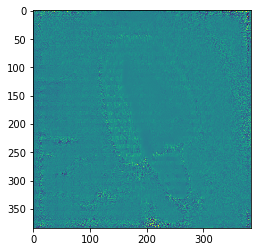

In [23]:
plt.imshow(np.reshape(model_gradient_ascent.layers[1].get_weights()[0],[384,384]))

In [24]:
model_gradient_ascent.layers[1].get_weights()[0].max()

3.4062958

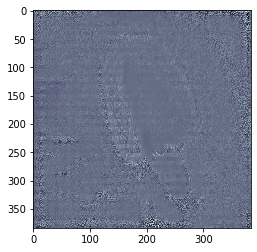

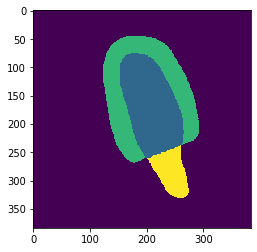

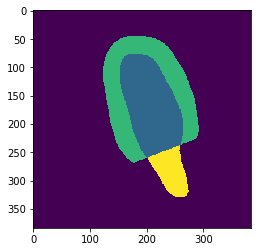

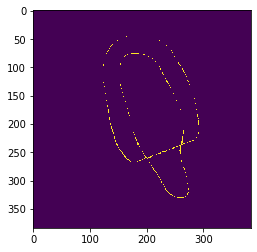

In [25]:
prediction = model_laddernet.predict(np.reshape(model_gradient_ascent.layers[1].get_weights()[0],[1,384,384,1]))
predicted_mask = np.array(tf.math.argmax(prediction[0,...], axis = 2))


plt.imshow(np.reshape(model_gradient_ascent.layers[1].get_weights()[0],[384,384]), cmap=plt.get_cmap('bone'))
plt.show()
plt.imshow(predicted_mask)
plt.show()
plt.imshow(test_mask_subset[0,...,0])
plt.show()
plt.imshow(predicted_mask != test_mask_subset[0,...,0])
plt.show()